In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('/mnt/c/Users/sohan/Projects/signal_synthesiser/')))

from src.data_loader import fetch_data
from src.indicators import calculate_features
from src.labelling import get_meta_labels

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Environment Setup Complete.")

Environment Setup Complete.


In [3]:
# Cell 2: Fetch Data (Updated)
ticker = "SPY"
print(f"Fetching {ticker} and VIX (Fear Index)...")

# Fetch SPY
df_spy = fetch_data(ticker, "2015-01-01", "2024-01-01")

# Fetch VIX (The Fear Index)
df_vix = fetch_data("^VIX", "2015-01-01", "2024-01-01")

# Combine them: We only want the 'Close' of VIX
df_raw = df_spy.copy()
df_raw['VIX'] = df_vix['Close']

print(f"Data Shape: {df_raw.shape}")

Fetching SPY and VIX (Fear Index)...
Loading SPY from cache...
Loading ^VIX from cache...
Data Shape: (2264, 6)


In [4]:
# Cell 3: Feature Engineering & Signal Generation
df_features = calculate_features(df_raw)

# Context Features
# Normalized VIX
df_features['VIX_Norm'] = df_features['VIX'].rolling(50).rank(pct=True)

# Seasonality
df_features['Is_Friday'] = np.where(df_features.index.dayofweek == 4, 1, 0)

# The Strategy Signals
# Binary columns (1 = Bullish Signal, 0 = Neutral/Bearish)

# Signal 1: RSI Mean Reversion
df_features['Signal_RSI'] = np.where(df_features['RSI'] < 30, 1, 0)

# Signal 2: Trend Following
df_features['Signal_Trend'] = np.where(df_features['Close'] > df_features['SMA_50'], 1, 0)

# Signal 3: MACD Momentum 
df_features['Signal_MACD'] = np.where(df_features['MACD_Line'] > df_features['MACD_Signal'], 1, 0)

# Signal 4: Bollinger Breakout 
df_features['Signal_Bollinger'] = np.where(df_features['Close'] > df_features['BB_Upper'], 1, 0)

# Labeling - (Triple Barrier)
df_labeled = get_meta_labels(df_features, window=5, barrier=0.015)
df_final = df_labeled.dropna()

print("Features & Signals Created.")
print("The 'Signal Council': RSI, Trend, MACD, Bollinger")
df_final[['Signal_RSI', 'Signal_Trend', 'Signal_MACD', 'Signal_Bollinger', 'Target_Label']].tail()

Features & Signals Created.
The 'Signal Council': RSI, Trend, MACD, Bollinger


,Signal_RSI,Signal_Trend,Signal_MACD,Signal_Bollinger,Target_Label
Date,,,,,
2023-12-15,0,1,1,1,0
2023-12-18,0,1,1,1,0
2023-12-19,0,1,1,1,0
2023-12-20,0,1,1,0,1
2023-12-21,0,1,1,0,0


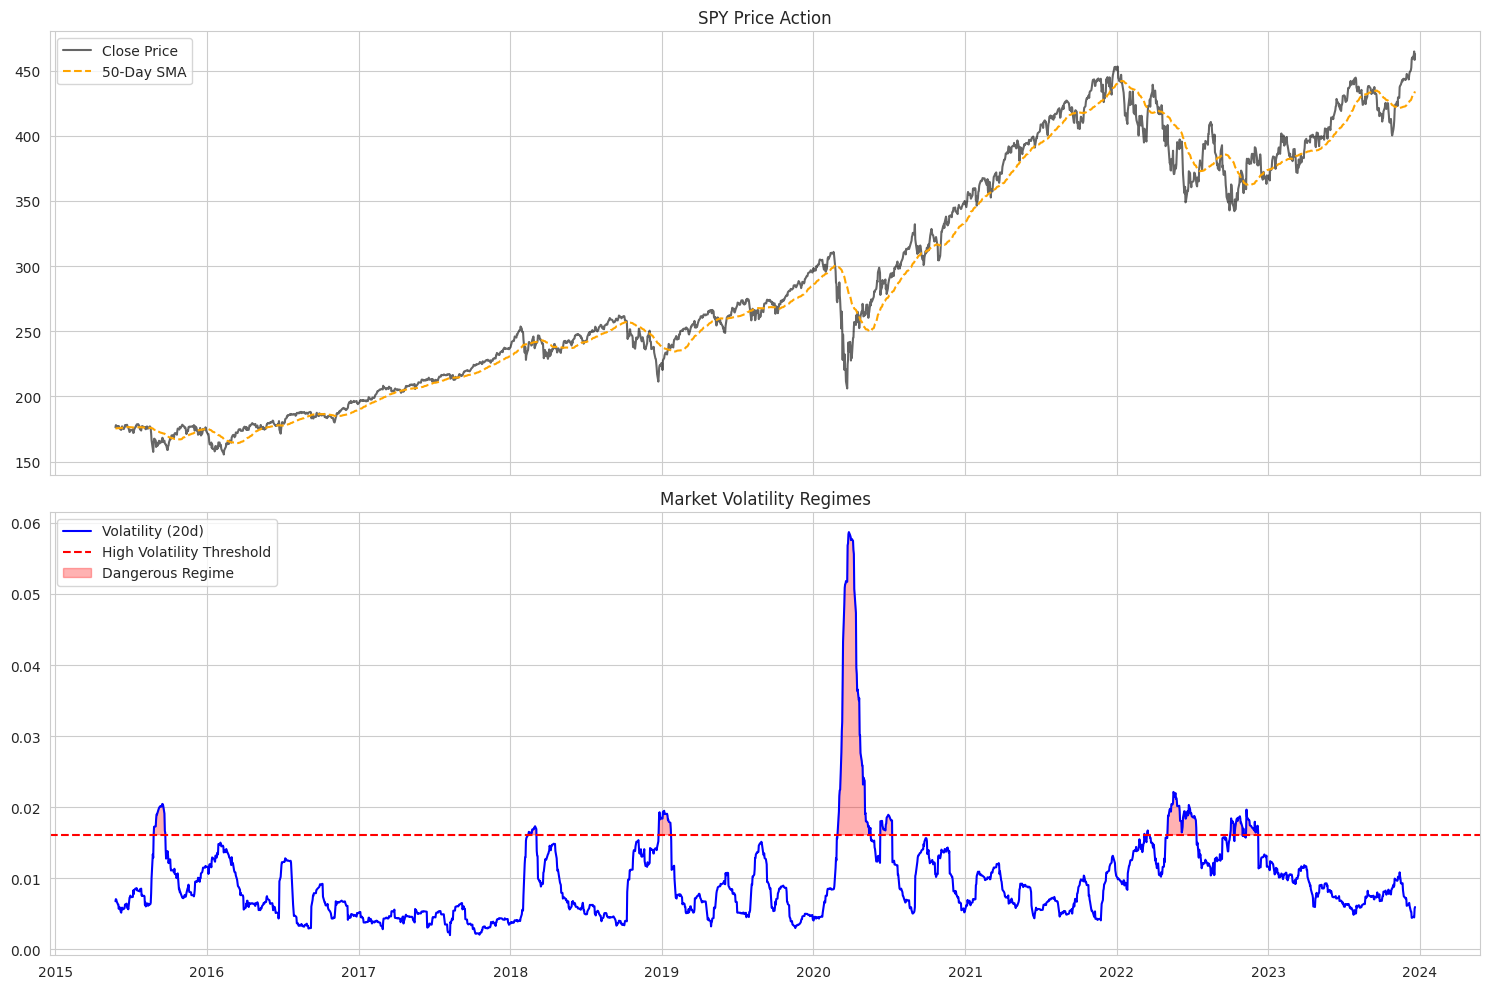

In [5]:
# Visualising Volatility Regimes
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

# Top: Price
ax[0].plot(df_final.index, df_final['Close'], label='Close Price', color='black', alpha=0.6)
ax[0].plot(df_final.index, df_final['SMA_50'], label='50-Day SMA', color='orange', linestyle='--')
ax[0].set_title(f"{ticker} Price Action")
ax[0].legend(loc='upper left')

# Bottom: Volatility
# Highlight high volatility zones in red
vol_threshold = df_final['Volatility'].mean() + df_final['Volatility'].std()
ax[1].plot(df_final.index, df_final['Volatility'], label='Volatility (20d)', color='blue')
ax[1].axhline(y=vol_threshold, color='red', linestyle='--', label='High Volatility Threshold')
ax[1].fill_between(df_final.index, df_final['Volatility'], vol_threshold, 
                   where=(df_final['Volatility'] > vol_threshold), 
                   color='red', alpha=0.3, label='Dangerous Regime')

ax[1].set_title("Market Volatility Regimes")
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

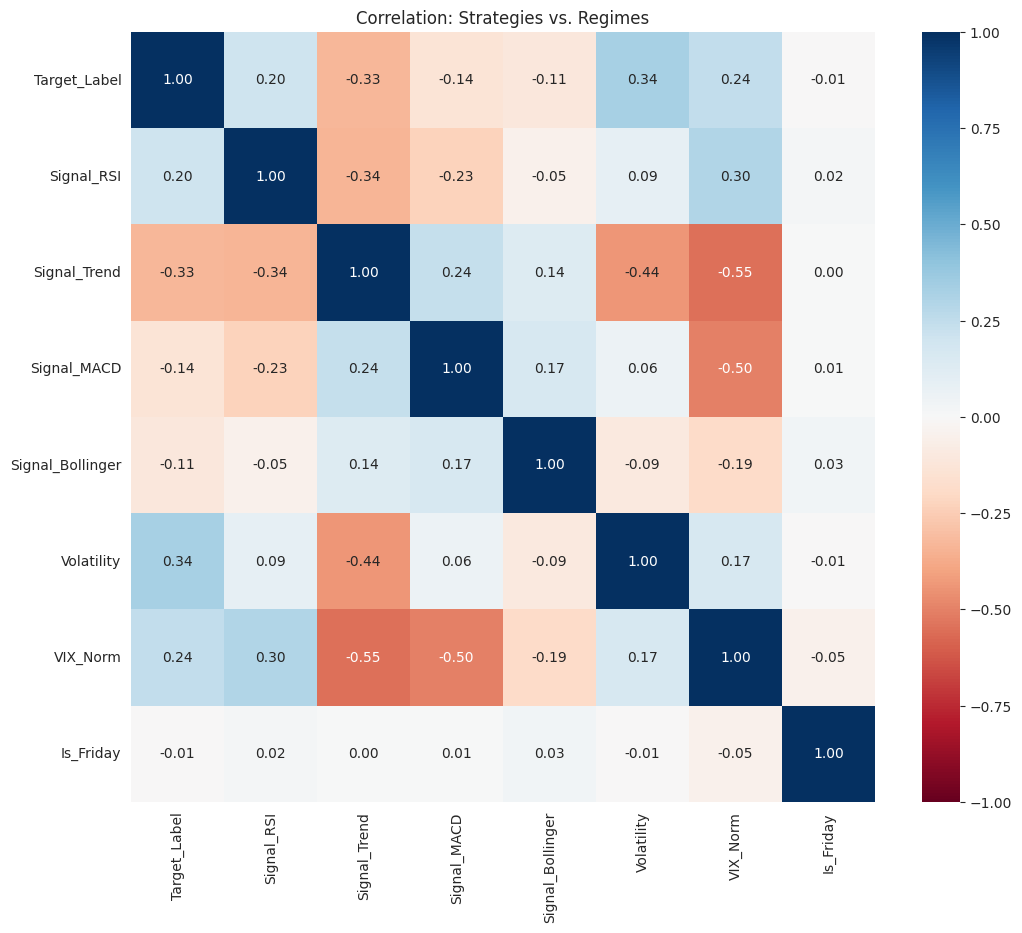

In [6]:
# Correlation Heatmap

# Select relevant columns
cols = [
    'Target_Label', 
    'Signal_RSI', 'Signal_Trend', 'Signal_MACD', 'Signal_Bollinger', # The Strategies
    'Volatility', 'VIX_Norm', 'Is_Friday' # The Weather
]

plt.figure(figsize=(12, 10))
sns.heatmap(df_final[cols].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation: Strategies vs. Regimes")
plt.show()

In [10]:
current_dir = os.getcwd()
if current_dir.endswith("signal_synthesiser"):
    project_root = current_dir
elif current_dir.endswith("notebooks"):
    project_root = os.path.dirname(current_dir)
else:
    project_root = os.path.dirname(current_dir)

save_dir = os.path.join(project_root, "data", "processed")
save_path = os.path.join(save_dir, "labelled_data.csv")

os.makedirs(save_dir, exist_ok=True)
df_final.to_csv(save_path)

print(f"Success! File saved to:\n{save_path}")

Success! File saved to:
/mnt/c/Users/sohan/Projects/signal_synthesiser/data/processed/labelled_data.csv
